# Two-layer Neural Network Workbook

----
NAME: Changyu Yan

UID: 304-566-451   

----

Import libraries and define relative error function, which is used to check results later. 

In [1]:
import random
import numpy as np
from tools.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Toy example

Before loading CIFAR-10, there will be a toy example to test your implementation of the forward and backward pass.

In [2]:
from lib.neural_net import TwoLayerNet

In [3]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model(): 
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

### Compute forward pass scores

In [4]:
## Implement the forward pass of the neural network.

# Note, there is a statement if y is None: return scores, which is why 
# the following call will calculate the scores.
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
    [-1.07260209,  0.05083871, -0.87253915],
    [-2.02778743, -0.10832494, -1.52641362],
    [-0.74225908,  0.15259725, -0.39578548],
    [-0.38172726,  0.10835902, -0.17328274],
    [-0.64417314, -0.18886813, -0.41106892]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

correct scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

Difference between your scores and correct scores:
3.381231210991542e-08


### Forward pass loss

The total loss includes data loss (MSE) and regularization loss, which is,

$$L = L_{data}+L_{reg} = \frac{1}{2N}\sum_{i=1}^{N}\left(\boldsymbol{y}_{\text{pred}}-\boldsymbol{y}_{\text{target}}\right)^2 + \frac{\lambda}{2} \left(||W_1||^2 + ||W_2||^2 \right)$$

More specifically in multi-class situation, if the output of neural nets from one sample is $y_{\text{pred}}=(0.1,0.1,0.8)$ and $y_{\text{target}}=(0,0,1)$ from the given label, then the MSE error will be $Error=(0.1-0)^2+(0.1-0)^2+(0.8-1)^2=0.06$

Implement data loss and regularization loss. In the MSE function, you also need to return the gradients which need to be passed backward. This is similar to batch gradient in linear regression. Test your implementation of loss functions. The Difference should be less than 1e-12.

In [5]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss_MSE = 1.8973332763705641 # check this number

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss_MSE)))

Difference between your loss and correct loss:
0.0


### Backward pass (You do not need to implemented this part)

We have already implemented the backwards pass of the neural network for you.  Run the block of code to check your gradients with the gradient check utilities provided. The results should be automatically correct (tiny relative error).

If there is a gradient error larger than 1e-8, the training for neural networks later will be negatively affected.

In [6]:
from tools.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('{} max relative error: {}'.format(param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 4.950799338590475e-10
b2 max relative error: 3.136457152639584e-11
W1 max relative error: 2.6774908292557593e-09
b1 max relative error: 3.464654106258009e-09


### Training the network

Implement neural_net.train() to train the network via stochastic gradient descent, much like the linear regression.

Final training loss:  0.03276043554222645


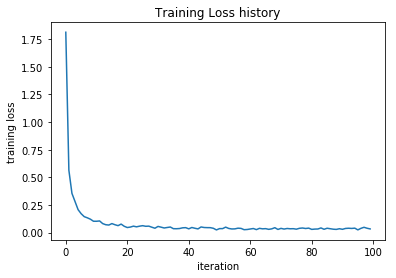

In [7]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

## Classify CIFAR-10

Do classification on the CIFAR-10 dataset.

In [8]:
from tools.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './tools/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


### Running SGD

If your implementation is correct, you should see a validation accuracy of around 15-18%.

In [9]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-5, learning_rate_decay=0.95,
            reg=0.1, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# Save this net as the variable subopt_net for later comparison.
subopt_net = net

iteration 0 / 1000: loss 0.5000420944058365
iteration 100 / 1000: loss 0.4998541596944857
iteration 200 / 1000: loss 0.4996073770825549
iteration 300 / 1000: loss 0.4993376609068653
iteration 400 / 1000: loss 0.49888433822922584
iteration 500 / 1000: loss 0.4986631919617844
iteration 600 / 1000: loss 0.4979940116432724
iteration 700 / 1000: loss 0.49684408181580586
iteration 800 / 1000: loss 0.4957105243596612
iteration 900 / 1000: loss 0.494153193949318
Validation accuracy:  0.173


In [10]:
stats['train_acc_history']

[0.085, 0.17, 0.19, 0.205, 0.18]

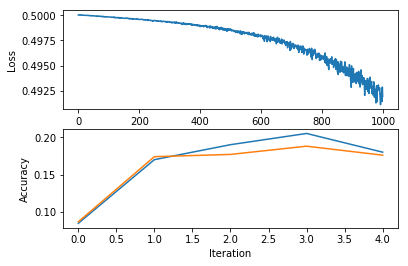

In [11]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.show()

### Questions:

The training accuracy isn't great. It seems even worse than simple KNN model, which is not as good as expected.

(1) What are some of the reasons why this is the case?  Take the following cell to do some analyses and then report your answers in the cell following the one below.

(2) How should you fix the problems you identified in (1)?

### Answers:

1. By the Universality Theorem, any continuous function can be realized by a network with one hidden layer, given enough hidden neurons. Therefore, we can infer that the reason why our current function is not good enough is because we do not have enough hidden neurons. It could also be because of the problems with hyperparameters, such as learning rate is too slow or too fast, regularization weight is too high, etc. 

2. We can add more hidden neurons in the hidden layer. We can also adjust the hyperparameters

---

## Optimize the neural network

Use the following part of the Jupyter notebook to optimize your hyperparameters on the validation set.  Store your nets as best_net.

In [12]:
best_net = TwoLayerNet(input_size, hidden_size, num_classes) # store the best model into this 

#   Optimize over your hyperparameters to arrive at the best neural
#   network.  You should be able to get over 45% validation accuracy.

input_size = 32 * 32 * 3 # do not change
hidden_size = 50 # do not change
num_classes = 10 # do not change
best_valacc = 0 # do not change

### <font color="blue"> Note: The following block will take a while to run</font>

In [13]:
%%capture
# Train the network

for i in range(100):
    stats = best_net.train(X_train, y_train, X_val, y_val,
                num_iters=500, batch_size=30,
                learning_rate=1e-5, learning_rate_decay=0.95,
                reg=0, verbose=True); 

In [14]:
# Predict on the validation set
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

best_valacc = val_acc
# Output your results
print("== Best parameter settings ==")
print("""num_iters=500    batch_size=30    learning_rate=1e-5    learning_rate_decay=0.95    reg=0""")
print("________________________________")
print("Best accuracy on validation set: {}".format(best_valacc))

Validation accuracy:  0.451
== Best parameter settings ==
num_iters=500    batch_size=30    learning_rate=1e-5    learning_rate_decay=0.95    reg=0
________________________________
Best accuracy on validation set: 0.451


### Quesions

(1) What is your best parameter settings? (Output from the previous cell)

(2) What parameters did you tune? How are they changing the performance of nerural network? You can discuss any observations from the optimization.

### Answers

1. num_iters=500    batch_size=30    learning_rate=1e-5    learning_rate_decay=0.95    reg=0

2. I tuned batch_size to make each iteration more efficient. I also changed regularization weight to 0, so make the model itself take complete control of the loss function. I also decreases the number of iterations in each training, but increased the number of training times, to gradually refine my model

---

## Visualize the weights of your neural networks

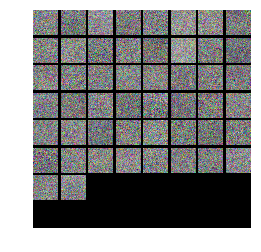

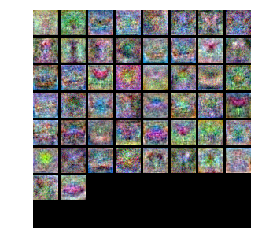

In [15]:
from tools.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.T.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(subopt_net)
show_net_weights(best_net)

### Questions:

What differences do you see in the weights between the suboptimal net and the best net you arrived at? What do the weights in neural networks probably learn after training?

### Answer:
The suboptimal net looks very scattered and irregular, while the best net looks very well clustered. We can tell the regions of each best net's node. The weights in a nerual network learn to form and detect certain shapes and patterns.

---

## Evaluate on test set 

In [16]:
test_acc = (best_net.predict(X_test) == y_test).mean()
#test_acc = (subopt_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.437


### Questions:
(1) What is your test accuracy by using the best NN you have got? How much does the performance increase compared with kNN? Why can neural networks perform better than kNN?

(2) Do you have any other ideas or suggestions to further improve the performance of neural networks other than the parameters you have tried in the homework? 

### Answers:

1. My test accuracy is 0.438. This is better than kNN by about 10%. Neural networks perform better than kNN because kNN always seem to underfit in our current settings. 

2. As mentioned, we can change the network structure. For example, we can increase the number of hidden layers and hidden neurals. We can also change the network to be convolutional, so it's more "personalized" for the data sets. 

---